## Open and pre-select data

In [1]:
import importlib
import my_functions

# Reload the module to reflect changes
importlib.reload(my_functions)

# Re-import the functions to update them
from my_functions import *

In [2]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=3000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi, dr_threshold=0.4)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]

100%|██████████| 3000/3000 [00:03<00:00, 841.13it/s]
494957it [01:55, 4287.50it/s]


## Plot pt, eta, phi

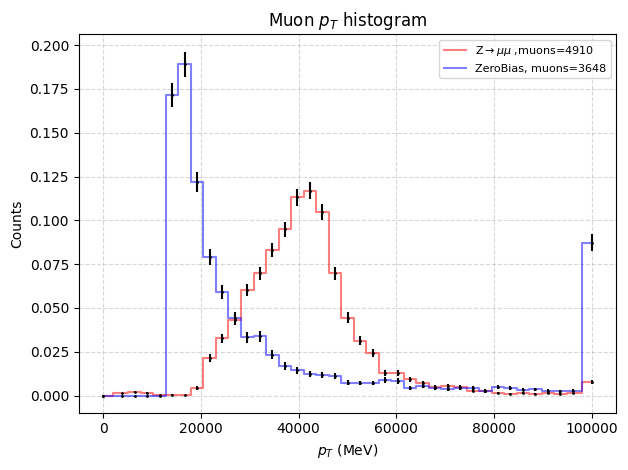

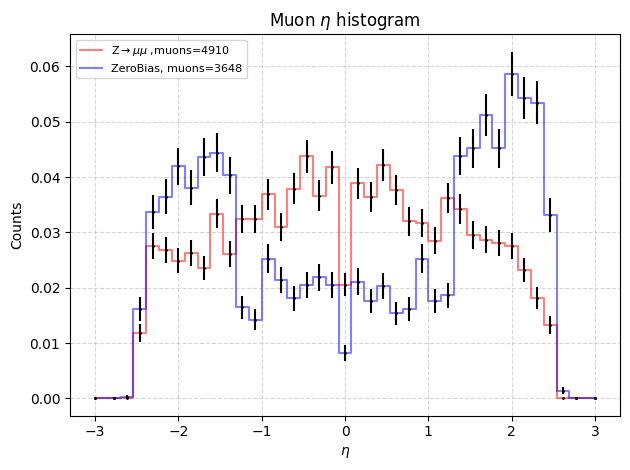

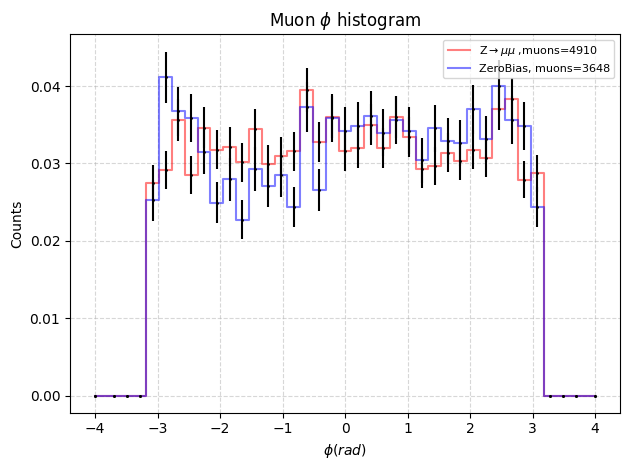

In [3]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))
coolplot([Zmumu_pt, ZeroBias_pt], np.linspace(0,10*10**4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="Muon $p_T$ histogram", x_label=r"$p_T$ (MeV)", y_label="Counts", plot_show=False)
plt.savefig('pt_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 40),
         labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts", plot_show=False)
plt.savefig('eta_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi (rad)$", y_label="Counts", plot_show=False)
plt.savefig('phi_hist.pdf', format='pdf')
plt.show()

## Compute and plot isolation

In [ ]:
fig2, axis2 = plt.subplots(2, 2, figsize=(12, 8))
fig3, axis3 = plt.subplots(2, 2, figsize=(12, 8))
fig4, axis4 = plt.subplots(1, 1, figsize=(10, 5))
#Set delta R - array length must be even in order to display subplots nicely
dr_mins=[0.0, 0.1, 0.1, 0.1]
dr_maxs=[0.2, 0.2, 0.3, 0.6]
#Set noise cut scaling factors
scalings=1.5

for i in range(len(dr_mins)):  
    print("Computing for dr=",[dr_mins[i],dr_maxs[i]],"...", i+1,"ouf of",len(dr_mins))
    dr_min=dr_mins[i]
    dr_max=dr_maxs[i]
    #Compute isolation energy
    res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                    event_range=[nmin1, nmax1], scaling=scalings)
    res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                event_range=[0, len(ZeroBias_eta)], scaling=scalings)
    #Plot it
    bins=np.linspace(0,30*10**3,40)
    row, col = divmod(i, 2)
    ax = axis2[row][col]

    aux=ak.flatten(res1)
    l1=len(aux[~np.isnan(aux)])
    aux=ak.flatten(res2)
    l2=len(aux[~np.isnan(aux)])

    coolplot(
        [res1, res2],
        bins=bins,
        labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
        x_label=r"$E_{iso}$ (MeV)",
        y_label="Counts",
        title=fr"Isolation energy, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}",
        ax=ax)

    #Compute ratios
    fig2.tight_layout()
    ratio1=ak.flatten(res1)/ak.flatten(Zmumu_pt)
    ratio1=ratio1[~np.isnan(ratio1)]
    l1=len(ratio1)

    ratio2=ak.flatten(res2)/ak.flatten(ZeroBias_pt)
    ratio2=ratio2[~np.isnan(ratio2)]
    l2=len(ratio2)

    #Plot them
    bins=np.linspace(0,1.0,40)
    row, col = divmod(i, 2)
    ax = axis3[row][col]
    
    coolplot(
    [ratio1, ratio2],
    bins=bins,
    labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
    x_label=r"$\frac{E_{iso}}{E_{t}}$ (MeV)",
    y_label="Counts",
    title=fr"$\frac{{E_{{iso}}}}{{E_{{t}}}}$ Ratio, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}",
    ax=ax)

    fig3.tight_layout()

    #Compute ROC
    bins=np.linspace(0,30000,1000)

    data1=ak.flatten(res1)
    data1=data1[~np.isnan(data1)]
    data2=ak.flatten(res2)
    data2=data2[~np.isnan(data2)]
    Zmumu_counts, _ = np.histogram(data1, bins)
    ZeroBias_counts, _ = np.histogram(data2, bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

    #Plot ROC
    FPR90=min(FPR[TPR >= 0.9])
    err=FPR_uncertainty(FPR90, len(data2))
    plt.scatter(FPR, TPR, marker='.', label=fr'$\Delta R=$[{dr_min}, {dr_max}, scaling={scalings}, FPR90={np.round(FPR90,3)}$\pm${np.round(err,3)}')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title(rf"ROC curves - Using isolation energies")
    plt.tight_layout()

##################################################################################################################################33


Computing for dr= [0.0, 0.2] ... 1 ouf of 4


muon_isolation_all_events: Computing muon isolation:  78%|███████▊  | 39/50 [02:11<00:39,  3.57s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7669ce05a660>>
Traceback (most recent call last):
  File "/home/ruben/anaconda3/envs/thesis/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
muon_isolation_all_events: Computing muon isolation:  96%|█████████▌| 48/50 [02:55<00:13,  6.86s/it]

Step 1 out of 9


Step 2 out of 9


Step 3 out of 9


Step 4 out of 9


Step 5 out of 9


Step 6 out of 9


Step 7 out of 9


/home/ruben/anaconda3/envs/thesis/lib/python3.13/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


Step 8 out of 9


Step 9 out of 9


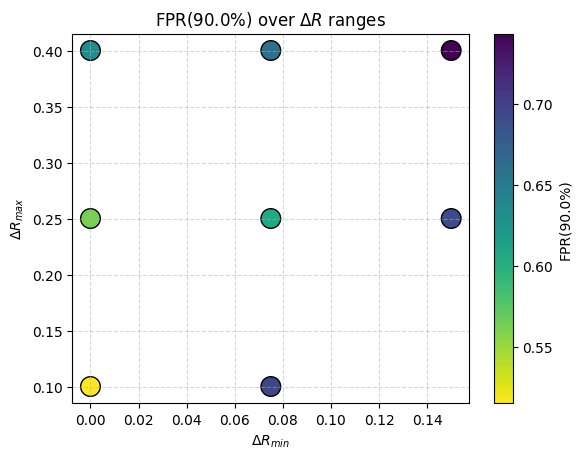

Top 5 lowest FPR(90%):
1. ΔR = [0.0, 0.1] → FPR = 0.5150136487716106
2. ΔR = [0.0, 0.25] → FPR = 0.562585969738652
3. ΔR = [0.075, 0.25] → FPR = 0.6063492063492063
4. ΔR = [0.0, 0.4] → FPR = 0.6352097130242825
5. ΔR = [0.075, 0.4] → FPR = 0.659171597633136


In [ ]:
points=3
iterations=1
next_dr_mins=np.linspace(0,0.15,points)
next_dr_maxs=np.linspace(0.10,0.4,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [0, len(ZeroBias_pt)],
                   min_range, max_range, points, bins=bins, scaling=scalings, use_ratio=False)

FPR_effs_not_none=FPR_effs[FPR_effs != None]

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs_not_none, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])

In [ ]:
mu=MuonTree_ZeroBias["AverageMu"].array()
l=len(ak.flatten(mu))
coolplot([mu], np.linspace(0,100,40), labels=[f"ZeroBias, muons={l}"],
          title=r"Average $\mu$", x_label=r"$\mu$", y_label="Counts", colors=['b'], plot_show=False)
plt.savefig(f'average_mu.pdf', format='pdf')
plt.show()

In [ ]:
scalings=1.0
dr_min=0.0
dr_max=0.2

res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                event_range=[nmin1, nmax1], scaling=scalings)
res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                            event_range=[0, len(ZeroBias_eta)], scaling=scalings)

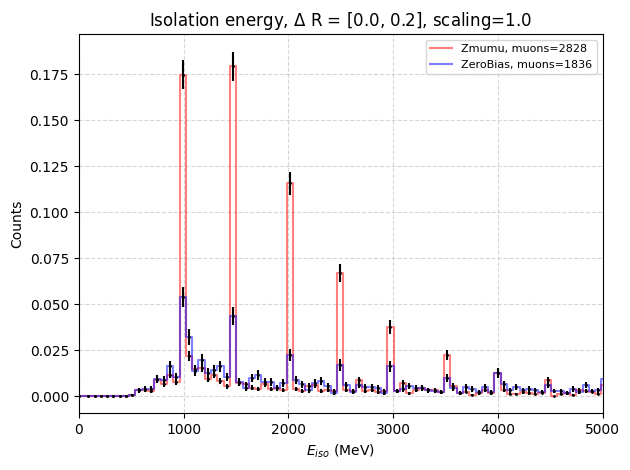

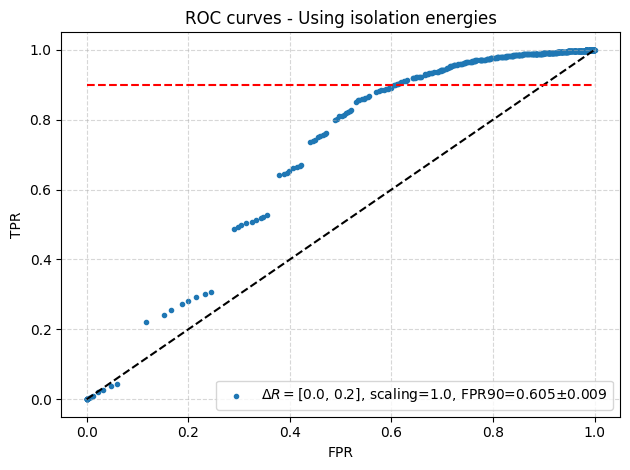

In [ ]:
bins=np.linspace(0,30000,int(500))

aux=ak.flatten(res1)
l1=len(aux[~np.isnan(aux)])
aux=ak.flatten(res2)
l2=len(aux[~np.isnan(aux)])
coolplot(
    [res1, res2],
    bins=bins,
    labels=[f"Zmumu, muons={l1}", f"ZeroBias, muons={l2}"],
    x_label=r"$E_{iso}$ (MeV)",
    y_label="Counts",
    title=fr"Isolation energy, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}", xlim=(0,5000))

#Compute ROC


data1=ak.flatten(res1)
data1=data1[~np.isnan(data1)]
data2=ak.flatten(res2)
data2=data2[~np.isnan(data2)]
Zmumu_counts, _ = np.histogram(data1, bins)
ZeroBias_counts, _ = np.histogram(data2, bins)
#Compute the cumulative sum of the counts (like integrating the histogram to the left)
Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
# Normalize to total events
TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

#Plot ROC
FPR90=min(FPR[TPR >= 0.9])
err=FPR_uncertainty(FPR90, len(data1))
plt.scatter(FPR, TPR, marker='.', 
            label=fr'$\Delta R=$[{dr_min}, {dr_max}], scaling={scalings}, FPR90={np.round(FPR90,3)}$\pm${np.round(err,3)}')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title(rf"ROC curves - Using isolation energies")
plt.tight_layout()

-Not schrink iso array
-Try 1,5 scaling
-Fix correlation plots (heatmaps for topocone)
-Where is the 90% position in iso histograms

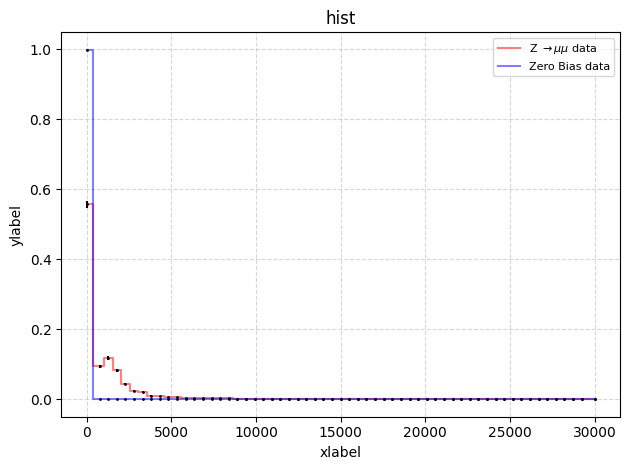

In [ ]:
coolplot([res_zmumu, res_zerobias],np.linspace(0,30000,60))

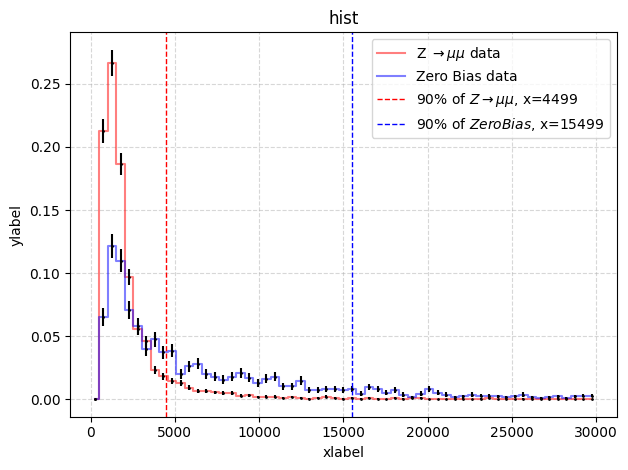

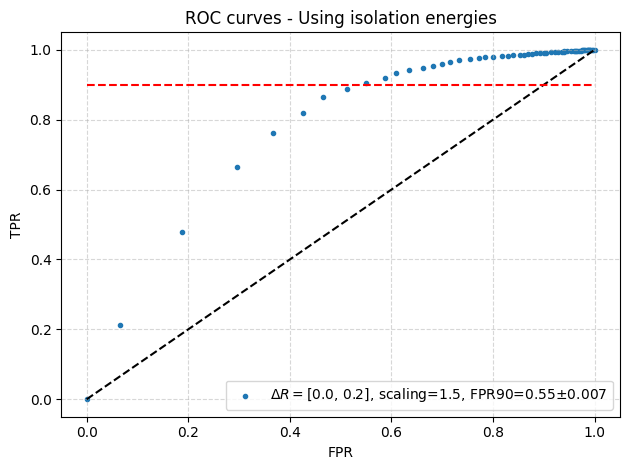

In [ ]:
bins=np.linspace(0.00010,30000,60)
data1=ak.flatten(res1)
data1=data1[~np.isnan(data1)]
data2=ak.flatten(res2)
data2=data2[~np.isnan(data2)]
Zmumu_counts, _ = np.histogram(data1, bins)
ZeroBias_counts, _ = np.histogram(data2, bins)
#Compute the cumulative sum of the counts (like integrating the histogram to the left)
Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
# Normalize to total events
TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

TPR_90=min(ak.where(TPR >= 0.9)[0])
TPR_90=(TPR_90+1)*((max(bins)-min(bins))/len(bins))

FPR_90=min(ak.where(FPR >= 0.9)[0])
FPR_90=(FPR_90+1)*((max(bins)-min(bins))/len(bins))

coolplot([res1, res2],bins, plot_show=False, collect_overflow=False, x_label=r"$\frac{E_{iso}}{E_{t}}$ (MeV)",
    y_label="Counts", title=fr"$\frac{{E_{{iso}}}}{{E_{{t}}}}$ Ratio, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scalings}",)
plt.axvline(x=TPR_90, color='r', linestyle='--', linewidth=1, label=rf"90% of $Z\to\mu\mu$, x={int(TPR_90)}")
plt.axvline(x=FPR_90, color='b', linestyle='--', linewidth=1, label=rf"90% of $ZeroBias$, x={int(FPR_90)}")
plt.legend()
plt.show()

#Plot ROC
FPR90=min(FPR[TPR >= 0.9])
err=FPR_uncertainty(FPR90, len(data1))
plt.scatter(FPR, TPR, marker='.', 
            label=fr'$\Delta R=$[{dr_min}, {dr_max}], scaling={scalings}, FPR90={np.round(FPR90,3)}$\pm${np.round(err,3)}')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title(rf"ROC curves - Using isolation energies")
plt.tight_layout()